## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---


--

Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [63]:
!pip install nlp

In [94]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.6.0


## Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [95]:
dataset=nlp.load_dataset('emotion')

Using custom data configuration default


In [96]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [98]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [99]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label'] for x in data]
  return tweets,labels

In [100]:
tweets,labels=get_tweet(train)

In [101]:
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Tokenizer

1. Tokenizing the tweets

In [102]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [139]:
tokenizer = Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [140]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [141]:
tweets[0]

'i didnt feel humiliated'

##  Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

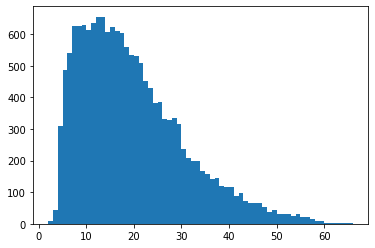

In [107]:
lengths=[len(t.split(' ')) for t in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [142]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [143]:
def get_sequences(tokenizer,tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded

In [144]:
padded_train_seq= get_sequences(tokenizer,tweets)

In [145]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

##  Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [146]:
classes=set(labels)
print(classes)

{'anger', 'surprise', 'sadness', 'joy', 'love', 'fear'}


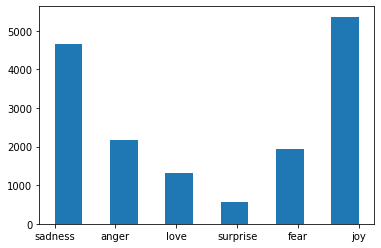

In [147]:
plt.hist(labels,bins=11)
plt.show()

In [148]:
class_to_index = dict((c,i) for i , c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [149]:
class_to_index

{'anger': 0, 'fear': 5, 'joy': 3, 'love': 4, 'sadness': 2, 'surprise': 1}

In [150]:
index_to_class

{0: 'anger', 1: 'surprise', 2: 'sadness', 3: 'joy', 4: 'love', 5: 'fear'}

In [153]:
names_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [154]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


## Creating the Model

1. Creating the model
2. Compiling the model

In [163]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000,16,input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')                            
])
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)

In [164]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            160000    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 40)                9760      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Training the Model

1. Preparing a validation set
2. Training the model

In [165]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
val_labels=names_to_ids(val_labels)

In [166]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [167]:
h = model.fit(
    padded_train_seq,train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)  
    ]
)

Epoch 1/20
500/500 [==============================] - 30s 50ms/step - loss: 1.3134 - accuracy: 0.4936 - val_loss: 0.8501 - val_accuracy: 0.6985
Epoch 2/20
500/500 [==============================] - 23s 47ms/step - loss: 0.6335 - accuracy: 0.7537 - val_loss: 0.6352 - val_accuracy: 0.7725
Epoch 3/20
500/500 [==============================] - 23s 47ms/step - loss: 0.3906 - accuracy: 0.8622 - val_loss: 0.4787 - val_accuracy: 0.8430
Epoch 4/20
500/500 [==============================] - 23s 47ms/step - loss: 0.2654 - accuracy: 0.9133 - val_loss: 0.3950 - val_accuracy: 0.8835
Epoch 5/20
500/500 [==============================] - 23s 47ms/step - loss: 0.1580 - accuracy: 0.9513 - val_loss: 0.3701 - val_accuracy: 0.8925
Epoch 6/20
500/500 [==============================] - 23s 47ms/step - loss: 0.1176 - accuracy: 0.9626 - val_loss: 0.4097 - val_accuracy: 0.8805
Epoch 7/20
500/500 [==============================] - 23s 47ms/step - loss: 0.0917 - accuracy: 0.9711 - val_loss: 0.3950 - val_accuracy:

##  Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

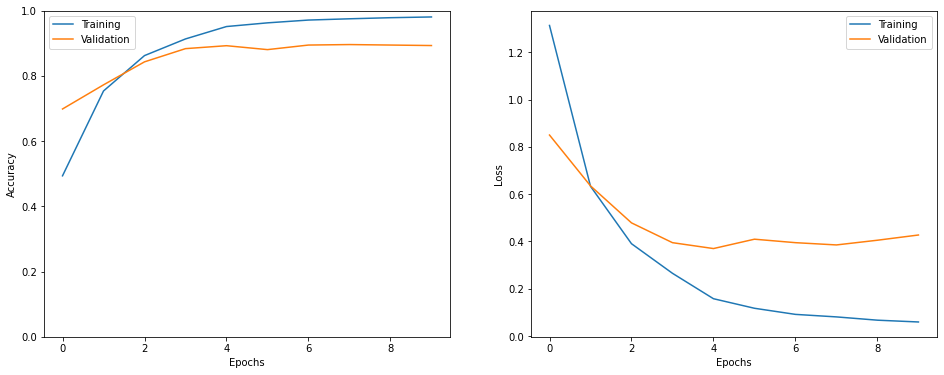

In [168]:
show_history(h)

In [59]:
test_tweets,test_labels=get_tweet(test)
test_seq = get_sequences(tokenizer,test_tweets)
test_labels = names_to_ids(test_labels)

In [185]:
_ = model.evaluate(test_seq,test_labels)

63/63 [==============================] - 1s 14ms/step - loss: 0.4271 - accuracy: 0.8760


In [187]:
i= random.randint(0, len(test_labels) - 1)
print('Sentance:',test_tweets[i])
print('Emotion:',index_to_class[test_labels[i]])

p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
pred_class=index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:',pred_class)

Sentance: i also baked enough cookies to take to my local bbw tomorrow night i feel so bad for the employees who have to work
Emotion: sadness
Predicted Emotion: fear


In [191]:
preds1=model.predict(test_seq)
preds = np.argmax(preds1,axis=1)


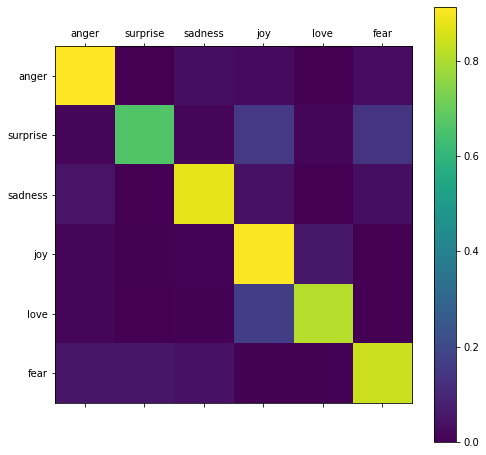

In [192]:
show_confusion_matrix(test_labels, preds , list(classes))

##Conclusion: 
We have came up with a model for tweet emotion recognition with **87.6%** Accuracy.

##Author: 
Shivani Balyan